In [1]:
import numpy as np
import sys
sys.path.insert(1,'/home/zhanibek/.local/lib/python2.7/site-packages/cv2')
sys.path.insert(1,'/home/zhanibek/catkin_ws/src/smart_tray/scripts/')
import cv2 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook
import pickle
import pandas as pd
from phri.utils import *
from tqdm.notebook import tqdm

import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets


## Functions

## Constants

In [2]:
meta_data_paths = [
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_sanket/trial_0/koh_sanket_trial_0_2020-10-11-20-48-27_meta_data_v2.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/koh_zhanibek/trial_0/koh_zhanibek_trial_0_2020-10-11-21-19-07_meta_data.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_0/trial_0_2020-10-12-14-47-43_meta_data.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/sanket_vignesh/trial_1/trial_1_2020-10-12-14-51-53_meta_data.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_sanket/trial_0/trial_0_2020-10-12-15-02-32_meta_data.pkl',
'/home/zhanibek/catkin_ws/src/smart_tray/data/rosbag/zhanibek_vignesh/trial_0/trial_0_2020-10-12-14-57-11_meta_data.pkl'
]

ann_paths = ['annotation - KOH_Sanket.csv','annotation - KOH_Zhanibek.csv']

ipath = 0

meta_data_path = meta_data_paths[ipath]
# ft_data_path = ft_data_paths[ipath]
ann_path = ann_paths[ipath]

In [3]:
meta_data = pickle.load(open(meta_data_path))

In [4]:
# ft_data = pickle.load(open(ft_data_path))

In [6]:
# all_observations = pickle.load(open('segmented_trials.pkl'))

In [7]:
ann_df0 = pd.read_csv(ann_path)
ann_df0.columns = ['obs_num', 'trajectory_type', 'motion_type', 'negotiation', 't0_cam_1_seq',
                  't0_sec', 'tf_cam_1_seq', 'tf_sec', 'duration', 't0_precise','tf_precise',
                  'duration_precise']

time_offset = float(ann_df0['t0_sec'][0])*1000
time_offset

1602467000.0

In [8]:
ann_df = ann_df0[5:]
ann_df

,obs_num,trajectory_type,motion_type,negotiation,t0_cam_1_seq,t0_sec,tf_cam_1_seq,tf_sec,duration,t0_precise,tf_precise,duration_precise
5,1.0,AB1,parallel,NaN,17475,1602467318,17920,1602467330,12,318.52,330.72,12.2
6,2.0,BA2,serial,NaN,18006,1602467332,18401,1602467341,9,332.2502,341.82,9.5698
7,3.0,AB1,serial,NaN,18487,343,18967,356,13,343.2432,356.6791,13.4359
8,4.0,BA1,parallel,NaN,19077,359,19520,372,13,359.1155,372.8226,13.7071
9,5.0,AB2,parallel,NaN,20655,402,21000,413,11,400.6725,412.6315,11.959
10,6.0,BA1,parallel,NaN,21010,413,21427,424,11,413.5273,424.9462,11.4189
11,7.0,AB2,parallel,NaN,21517,427,21945,439,12,426.8303,438.7669,11.9366
12,8.0,BA2,serial,NaN,22016,440,22349,449,9,440.0744,450.4536,10.3792
13,9.0,AB2,parallel,NaN,22476,453,22820,463,10,452.9302,463.0416,10.1114
14,10.0,BA2,parallel,NaN,23287,476,23654,486,10,477.0748,486.4523,9.3775


In [21]:
def read_rft(tt0,ttf, temp_df):
    
    cut = temp_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = temp_df[cut]

    force =  dict(temp)['force'].to_numpy()
    force = np.array([[f[0],f[1],f[2]] for f in force])

    torque =  dict(temp)['torque'].to_numpy()
    torque = np.array([[f[0],f[1],f[2]] for f in torque])
    
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    frame_id = temp_df.frame_id.iloc[0]
    
    new_force = np.zeros(force.shape)
    new_torque = new_force.copy()
    # Sensor 1
    if frame_id =='C00300119':        
        new_force[:,0] = force[:,2]
        new_force[:,1] = force[:,0]
        new_force[:,2] = force[:,1]
        
        new_torque[:,0] = torque[:,2]
        new_torque[:,1] = torque[:,0]
        new_torque[:,2] = torque[:,1]
    # Sensor 2    
    elif frame_id =='C00300122':
        new_force[:,0] = -force[:,2]
        new_force[:,1] = -force[:,0]
        new_force[:,2] = force[:,1]
        
        new_torque[:,0] = -torque[:,2]
        new_torque[:,1] = -torque[:,0]
        new_torque[:,2] = torque[:,1]
        
    res = {'time_steps': tsteps, 'force': new_force, 'torque':new_torque, 'frame_id':frame_id }
    
    return res

def read_imu(tt0, ttf, temp_df):

    cut = imu_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = imu_df[cut]

    accel =  dict(temp)['accel'].to_numpy()
    accel = np.array([[f[0],f[1],f[2]] for f in accel])

    gyro =  dict(temp)['gyro'].to_numpy()
    gyro = np.array([[f[0],f[1],f[2]] for f in gyro])

    mag =  dict(temp)['mag'].to_numpy()
    mag = np.array([[f[0],f[1],f[2]] for f in mag])
    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    
    
    new_accel = np.zeros(accel.shape)
    new_gyro = new_accel.copy()
    new_mag = new_gyro.copy()
       
    new_accel[:,0] = accel[:,0]
    new_accel[:,1] = -accel[:,1]
    new_accel[:,2] = -accel[:,2]

    new_mag[:,0] = mag[:,0]
    new_mag[:,1] = -mag[:,1]
    new_mag[:,2] = -mag[:,2]
    
    new_gyro[:,0] = gyro[:,0]
    new_gyro[:,1] = -gyro[:,1]
    new_gyro[:,2] = -gyro[:,2]
    
    res = {'time_steps': tsteps, 'accel': new_accel, 'gyro':new_gyro, 'mag':new_mag, 'frame_id': temp.frame_id.iloc[0]}

    return res


def read_pose(tt0, ttf, pose_df):

    cut = pose_df.time_stamp.apply(lambda x: x>=tt0 and x<=ttf)
    temp = pose_df[cut]

    position =  dict(temp)['position'].to_numpy()
    position = np.array([[f[0],f[1],f[2]] if not np.isnan(f).any() else [np.nan,np.nan,np.nan] for f in position ])

    quat =  dict(temp)['quaternion'].to_numpy()
    quat = np.array([[f[0],f[1],f[2],f[3]] if not np.isnan(f).any() else [np.nan,np.nan,np.nan,np.nan] for f in quat])

    tsteps = dict(temp)['time_stamp'].to_numpy()
    tsteps -= tt0
    
        
    res = {'time_steps': tsteps, 'position': position, 'quaternion':quat, 'frame_id': pose_df.frame_id.iloc[0]}

    return res


def merge_offline_pos(pos, pos_off,txt='_merged'):
    res = {}
    tt = np.concatenate((pos['time_steps'], pos_off['time_steps']))
    pp = np.concatenate((pos['position'], pos_off['position']))
    qq = np.concatenate((pos['quaternion'], pos_off['quaternion']))

    # drop duplicate values
    _, indx = np.unique(tt, return_index=True)

    tt = tt[indx]
    pp = pp[indx]
    qq = qq[indx]
    # sort once more timewise
    sind = np.argsort(tt)
    tt = tt[sind]
    pp = pp[sind]
    qq = qq[sind]
    
    res = {'time_steps': tt, 'position': pp, 'quaternion':qq, 'frame_id': pos['frame_id']+txt}
    return res

In [22]:
total_obs = ann_df.shape[0]
observations = []
rft1_df = meta_data['/RFT_FORCE']
rft2_df = meta_data['/RFT_FORCE_2']
imu_df = meta_data['/imu_data']

pose1_df = meta_data['/cam1_tray_grf']
pose1_off_df = meta_data['camera_1_grf_offline']

pose2_df = meta_data['/cam2_tray_grf']
pose2_off_df = meta_data['camera_2_grf_offline']

pose3_df = meta_data['/cam3_tray_grf']
pose3_off_df = meta_data['camera_3_grf_offline']

for obs_num in tqdm(range(1,total_obs+1)):

    tt0 = float(ann_df.t0_precise[ann_df.obs_num==obs_num])+time_offset
    ttf = float(ann_df.tf_precise[ann_df.obs_num==obs_num])+time_offset
    
    rft1 = read_rft(tt0,ttf, rft1_df)
    rft2 = read_rft(tt0,ttf, rft2_df)
    
    imu = read_imu(tt0, ttf, imu_df)
    
    pose1_grf = read_pose(tt0, ttf, pose1_df)
    pose1_off_grf = read_pose(tt0, ttf, pose1_off_df)
    pose1_merged = merge_offline_pos(pose1_grf, pose1_off_grf)
    
    pose2_grf = read_pose(tt0, ttf, pose2_df)
    pose2_off_grf = read_pose(tt0, ttf, pose2_off_df)
    pose2_merged = merge_offline_pos(pose2_grf, pose2_off_grf)
    
    pose3_grf = read_pose(tt0, ttf, pose3_df)
    pose3_off_grf = read_pose(tt0, ttf, pose3_off_df)
    pose3_merged = merge_offline_pos(pose3_grf, pose3_off_grf)
    
    
    pos123 = merge_offline_pos(pose1_merged, pose2_merged, txt='123')
    pos123 = merge_offline_pos(pos123, pose3_merged, txt='123')
    
    traj_type = ann_df.trajectory_type[ann_df.obs_num==obs_num].iloc[0]
    motion_type = ann_df.motion_type[ann_df.obs_num==obs_num].iloc[0]
    
    obs = {'rft1': rft1, 'rft2': rft2, 'imu':imu, 
           'pose1_grf': pose1_grf, 'pose2_grf': pose2_grf, 'pose3_grf': pose3_grf,
           'pose1_merged':pose1_merged, 'pose2_merged':pose2_merged, 'pose3_merged':pose3_merged,
           'pose123':pos123,
           'pose1_off_grf': pose1_off_grf, 'pose2_off_grf': pose2_off_grf, 'pose3_off_grf': pose3_off_grf,
           'traj_type':traj_type, 'motion_type': motion_type}
    
    
    observations.append(obs)

In [23]:
aa = meta_data.keys()
aa.sort()
aa

['/RFT_FORCE',
 '/RFT_FORCE_2',
 '/cam1_tray_grf',
 '/cam1_tray_pose_estimation',
 '/cam2_tray_grf',
 '/cam2_tray_pose_estimation',
 '/cam3_tray_grf',
 '/cam3_tray_pose_estimation',
 '/imu_data',
 'camera_1',
 'camera_1_grf_offline',
 'camera_1_raw_pose_offline',
 'camera_2',
 'camera_2_grf_offline',
 'camera_2_raw_pose_offline',
 'camera_3',
 'camera_3_grf_offline',
 'camera_3_raw_pose_offline',
 'summary']

### Draw 123 merged position

In [44]:
obs = observations[7]

BA2 serial


(0, 15)

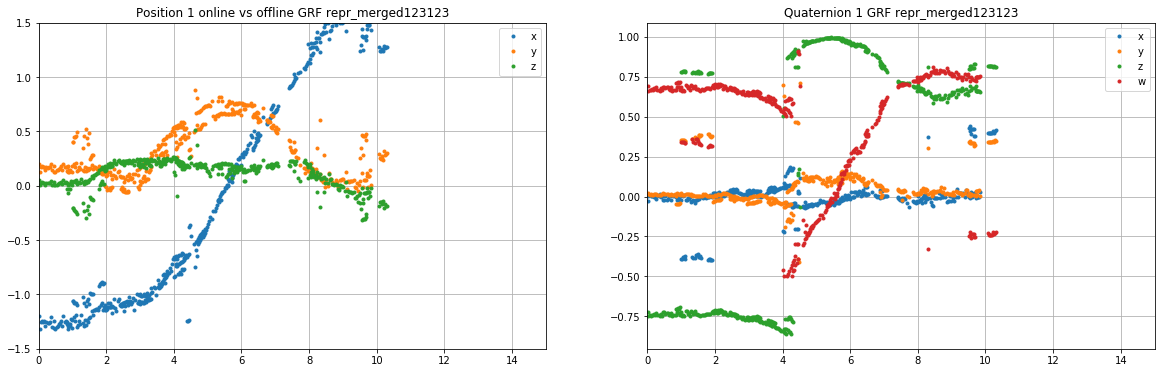

In [45]:
h = 1
w = 2
ylim = 1.5
xlim = 15

plt.figure(figsize=(20,h*6))

           
print obs['traj_type'], obs['motion_type']

# Position from camera 1
plt.subplot(h,w,1)
plt.plot(obs['pose123']['time_steps'], obs['pose123']['position'], '.', alpha=1)
plt.legend(['x','y','z'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose123']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,2)
plt.plot(obs['pose123']['time_steps'], obs['pose123']['quaternion'], '.', alpha=1)
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose123']['frame_id'])
plt.grid()

plt.xlim(0, xlim)



### Draw merged position

In [24]:
obs = observations[0]

AB1 parallel


(0, 15)

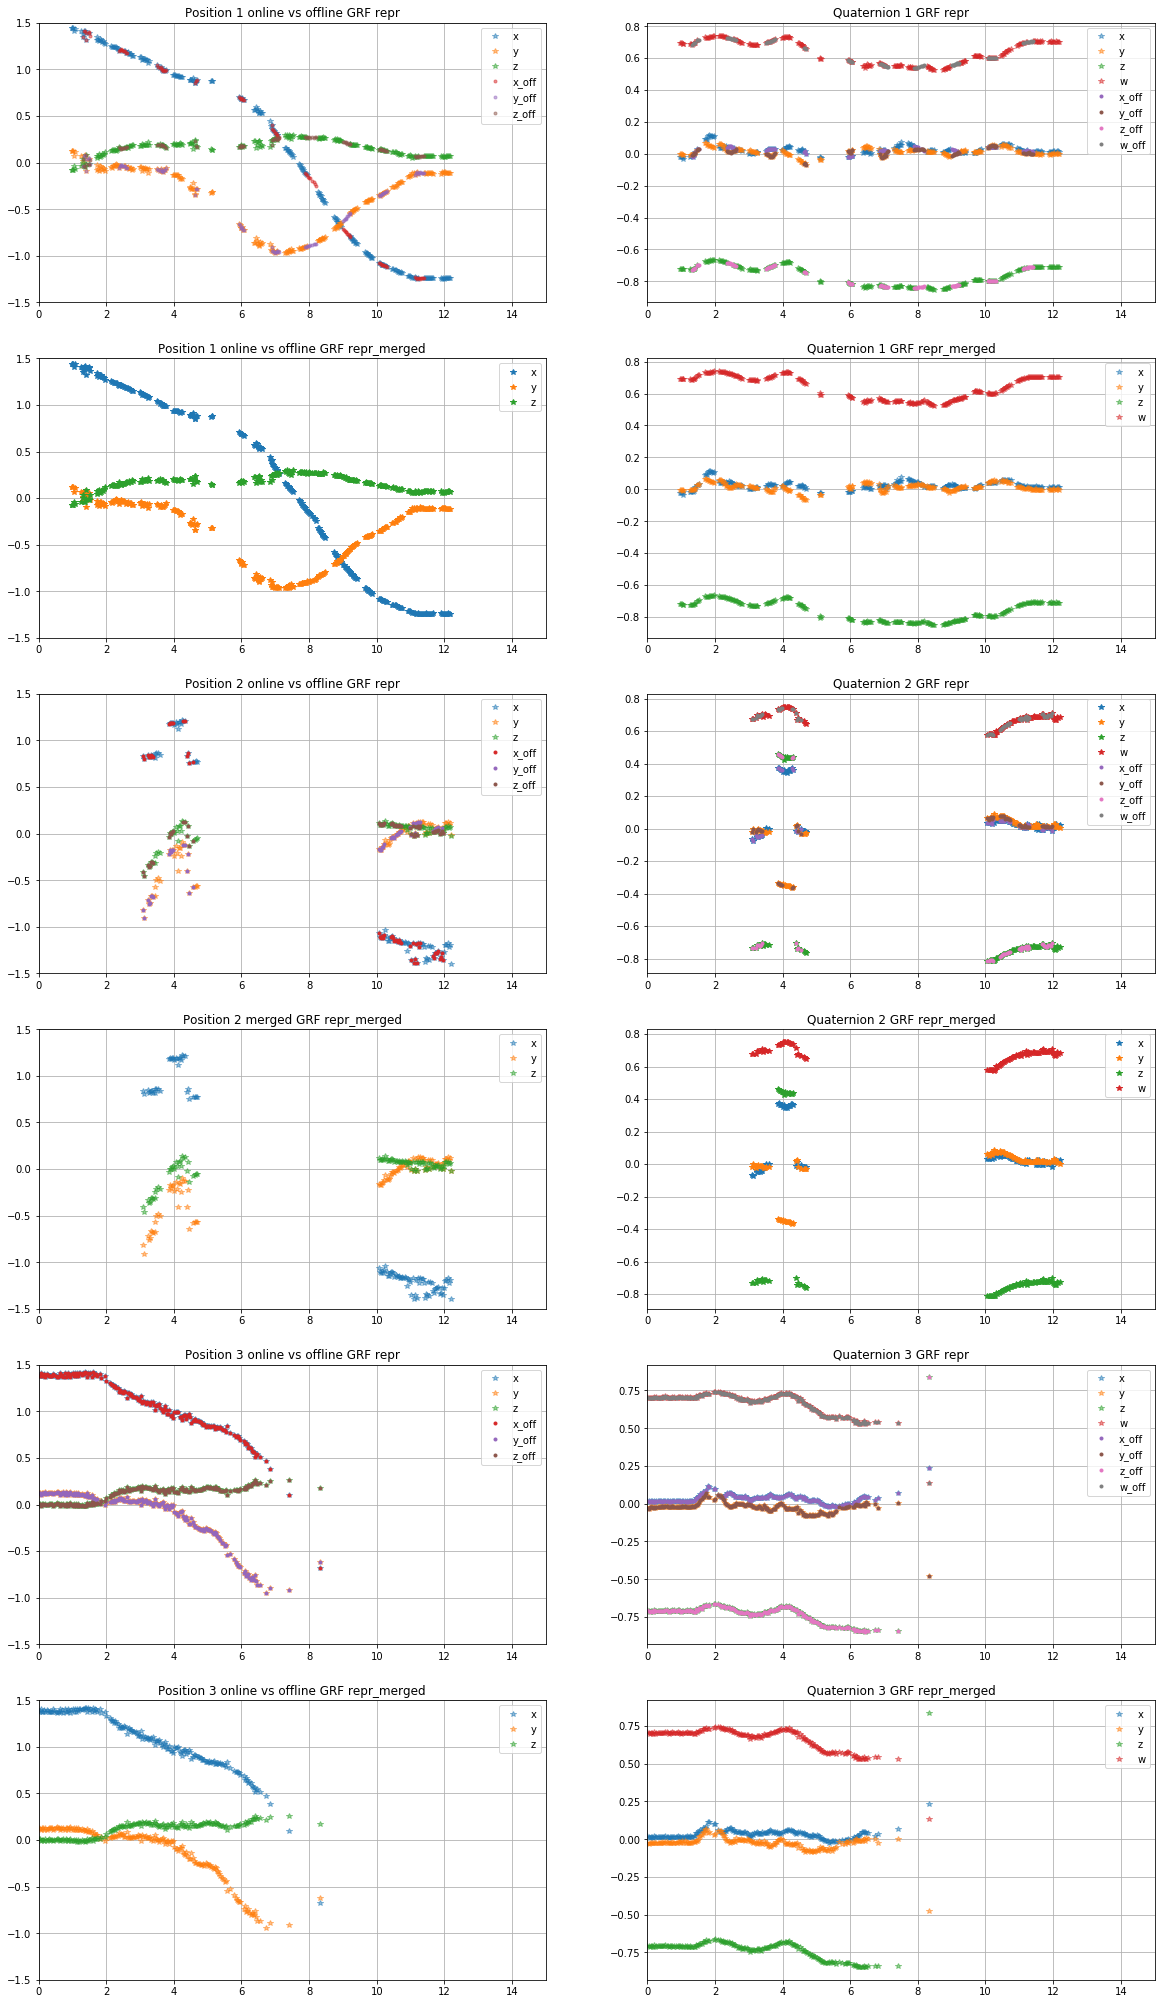

In [25]:
h = 6
w = 2
ylim = 1.5
xlim = 15

plt.figure(figsize=(20,h*6))

           
print obs['traj_type'], obs['motion_type']

# Position from camera 1
plt.subplot(h,w,1)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.', alpha=0.5)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,2)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,3)
plt.plot(obs['pose1_merged']['time_steps'], obs['pose1_merged']['position'], '*')
plt.legend(['x','y','z'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,4)
plt.plot(obs['pose1_merged']['time_steps'], obs['pose1_merged']['quaternion'], '*', alpha=0.5)
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_merged']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 2
plt.subplot(h,w,5)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.', alpha=1)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,6)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,7)
plt.plot(obs['pose2_merged']['time_steps'], obs['pose2_merged']['position'],'*', alpha=0.5)
plt.legend(['x','y','z'])
plt.gca().set_title('Position 2 merged %s'%obs['pose2_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,8)
plt.plot(obs['pose2_merged']['time_steps'], obs['pose2_merged']['quaternion'],'*')
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_merged']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 3
plt.subplot(h,w,9)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,10)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()
plt.xlim(0, xlim)


# Merged
plt.subplot(h,w,11)
plt.plot(obs['pose3_merged']['time_steps'], obs['pose3_merged']['position'],'*', alpha=0.5)
plt.legend(['x','y','z'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_merged']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,12)
plt.plot(obs['pose3_merged']['time_steps'], obs['pose3_merged']['quaternion'],'*', alpha=0.5)
plt.legend(['x','y','z', 'w'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_merged']['frame_id'])
plt.grid()
plt.xlim(0, xlim)

### Draw position variables

In [ ]:
obs = observations[16]

In [ ]:
h = 3
w = 2
ylim = 1.5
xlim = 18

plt.figure(figsize=(20,h*6))

           
print obs['traj_type'], obs['motion_type']

# Position from camera 1
plt.subplot(h,w,1)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.', alpha=0.5)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,2)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*', alpha=0.5)
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 2
plt.subplot(h,w,3)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.', alpha=1)
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)

plt.subplot(h,w,4)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.xlim(0, xlim)


# Position from camera 3
plt.subplot(h,w,5)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()

plt.ylim(-ylim, ylim)
plt.xlim(0, xlim)


plt.subplot(h,w,6)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*', alpha=0.5)
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()
plt.xlim(0, xlim)

In [ ]:
obs['pose1_grf']['time_steps'].shape

In [ ]:
tt = np.concatenate((obs['pose1_grf']['time_steps'], obs['pose1_off_grf']['time_steps']))
pp = np.concatenate((obs['pose1_grf']['position'], obs['pose1_off_grf']['position']))
qq = np.concatenate((obs['pose1_grf']['quaternion'], obs['pose1_off_grf']['quaternion']))

In [ ]:
tt.shape, pp.shape

In [ ]:
_, indx = np.unique(tt, return_index=True)

tt = tt[indx]
pp = pp[indx]
sind = np.argsort(tt)
tt = tt[sind]

In [ ]:
tt.shape

In [ ]:
plt.plot(tt[sind],pp[sind])
plt.xlim(0,xlim)

plt.figure()
plt.plot(tt[sind],pp[sind],'.', MarkerSize=1.2)
plt.xlim(0,xlim)

plt.figure()
plt.plot(tt[sind],qq[sind],'.', MarkerSize=1.2)
plt.xlim(0,xlim)

plt.figure()
plt.plot(obs['pose1_grf']['time_steps'],obs['pose1_grf']['position'], '.', MarkerSize=1.2)
plt.xlim(0,xlim)

In [ ]:
tt.shape

### Draw all channels

In [ ]:
h = 10
w = 2

plt.figure(figsize=(20,h*10))

           
print obs['traj_type'], obs['motion_type']

# plt.title('{} {}'.format(obs['traj_type'],obs['motion_type']))

plt.subplot(h,w,1)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Force %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(h,w,2)
plt.plot(obs['rft1']['time_steps'], obs['rft1']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT1 Torque %s'%obs['rft1']['frame_id'])
plt.grid()

plt.subplot(h,w,3)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['force'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Force %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(h,w,4)
plt.plot(obs['rft2']['time_steps'], obs['rft2']['torque'])
plt.legend(['x','y','z'])
plt.gca().set_title('RFT2 Torque %s'%obs['rft2']['frame_id'])
plt.grid()


plt.subplot(h,w,5)
plt.plot(obs['imu']['time_steps'], obs['imu']['accel'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Accel %s'%obs['imu']['frame_id'])
plt.grid()


plt.subplot(h,w,6)
plt.plot(obs['imu']['time_steps'], obs['imu']['gyro'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Gyro %s'%obs['imu']['frame_id'])
plt.grid()

plt.subplot(h,w,7)
plt.plot(obs['imu']['time_steps'], obs['imu']['mag'])
plt.legend(['x','y','z'])
plt.gca().set_title('IMU Mag %s'%obs['imu']['frame_id'])
plt.grid()

# Position from camera 1
plt.subplot(h,w,8)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['position'], '*')
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 1 online vs offline %s'%obs['pose1_grf']['frame_id'])
plt.grid()


plt.subplot(h,w,9)
plt.plot(obs['pose1_grf']['time_steps'], obs['pose1_grf']['quaternion'], '*')
plt.plot(obs['pose1_off_grf']['time_steps'], obs['pose1_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 1 %s'%obs['pose1_grf']['frame_id'])
plt.grid()


# Position from camera 2
plt.subplot(h,w,10)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['position'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 2 online vs offline %s'%obs['pose2_grf']['frame_id'])
plt.grid()

plt.subplot(h,w,11)
plt.plot(obs['pose2_grf']['time_steps'], obs['pose2_grf']['quaternion'],'*')
plt.plot(obs['pose2_off_grf']['time_steps'], obs['pose2_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 2 %s'%obs['pose2_grf']['frame_id'])
plt.grid()


# Position from camera 3
plt.subplot(h,w,12)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['position'],'*')
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['position'], '.')
plt.legend(['x','y','z', 'x_off','y_off','z_off'])
plt.gca().set_title('Position 3 online vs offline %s'%obs['pose3_grf']['frame_id'])
plt.grid()


plt.subplot(h,w,13)
plt.plot(obs['pose3_grf']['time_steps'], obs['pose3_grf']['quaternion'],'*')
plt.plot(obs['pose3_off_grf']['time_steps'], obs['pose3_off_grf']['quaternion'], '.')
plt.legend(['x','y','z', 'w', 'x_off','y_off','z_off', 'w_off'])
plt.gca().set_title('Quaternion 3 %s'%obs['pose3_grf']['frame_id'])
plt.grid()


In [366]:
# all_observations = all_observations+observations

In [20]:
# pickle.dump(all_observations, open('segmented_trials.pkl', 'w'))